<a href="https://colab.research.google.com/github/Katrin-Leberfinger/Hybrid-gender-debiased-music-recommendation/blob/main/04_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.5 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 6.6 MB 85.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from transformers import BertConfig, BertPreTrainedModel, BertModel, BertForSequenceClassification
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch import nn
from transformers import BertModel
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import gc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Read Data

## Datasets

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDataset(Dataset):
    def __init__(self, data_all,tokenizer,max_length, text_col, item2pos, user2id):
        super(LFM2bDataset, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index][self.text_col]
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        target = self.data_all.iloc[index]['count']

        inputs = tokenizer.encode_plus(
                text1, 
                add_special_tokens=True,
                padding='max_length',
                max_length = self.max_length,
                return_tensors='pt',
                truncation=True,
                return_attention_mask=True
                )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            'input_ids_lyrics': ids.flatten(),
            'attention_mask_lyrics': mask.flatten(),
            'user_id': torch.tensor(user_id, dtype=torch.long),
             'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.FloatTensor([target])
            }


In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LFM2bDatasetMulitpleText(Dataset):
    def __init__(self, data_all,tokenizer,max_length, item2pos, user2id):
        super(LFM2bDatasetMulitpleText, self).__init__()
        self.data_all = data_all
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.item2pos = item2pos
        self.user2id = user2id
        
    def __len__(self):
        return len(self.data_all)
    
    def __getitem__(self, index):
        
        text1 = self.data_all.iloc[index]['lyrics_cleaned']
        text2 = self.data_all.iloc[index]['tags']
        text3 = self.data_all.iloc[index]['abstract']
        user_id = self.user2id[ self.data_all.iloc[index]['user_id']]
        track_id = self.item2pos[ self.data_all.iloc[index]['track_id']]
        
        inputs1 = tokenizer.encode_plus(
            text1, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        inputs2 = tokenizer.encode_plus(
            text2, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        inputs3 = tokenizer.encode_plus(
            text3, 
            add_special_tokens=True,
            padding='max_length',
            max_length = self.max_length,
            return_tensors='pt',
            truncation=True,
            return_attention_mask=True
            
        )
        ids3 = inputs1["input_ids"]
        mask3 = inputs1["attention_mask"]

        return {
            'input_ids_lyrics': torch.tensor(ids1, dtype=torch.long),
            'attention_mask_lyrics': torch.tensor(mask1, dtype=torch.long),
            'input_ids_tags': torch.tensor(ids2, dtype=torch.long),
            'attention_mask_tags': torch.tensor(mask2, dtype=torch.long),
            'input_ids_abstract': torch.tensor(ids3, dtype=torch.long),
            'attention_mask_abstract': torch.tensor(mask3, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long),
            'track_id': torch.tensor(track_id, dtype=torch.long),
            'target': torch.tensor(self.data_all.iloc[index]['count'], dtype=torch.float)
            }


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Master\ Thesis/data

/content/drive/MyDrive/Master Thesis/data


In [8]:
from model import EasyBERTModel, AMARBertEmbeddings, AMARBert, MatrixFactorizationModel

## Read Data: Lyrics 

In [9]:
dir = "preprocessed_data_binary_movies/"

data_interaction = pd.read_csv(dir + "data_interaction.csv").drop(['Unnamed: 0'],axis=1)
data_tracks_tags_lyrics = pd.read_csv(dir + "data_tracks_tags_lyrics.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_test = pd.read_csv(dir + "data_interaction_test.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_train = pd.read_csv(dir + "data_interaction_train.csv").drop(['Unnamed: 0'],axis=1)
data_interaction_val = pd.read_csv(dir + "data_interaction_val.csv").drop(['Unnamed: 0'],axis=1)

In [10]:
data_interaction_train["abstract"] = data_interaction_train["abstract"].str.lower()
data_interaction_test["abstract"] = data_interaction_test["abstract"].str.lower()
data_interaction_val["abstract"] = data_interaction_val["abstract"].str.lower()

In [11]:
pos2item = {i:v for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}
item2pos = {v:i for i, v in enumerate(data_tracks_tags_lyrics.track_id.sort_values().unique())}

id2user = {i:v for i, v in enumerate(data_interaction.user_id.sort_values().unique())}
user2id = {v:i for i, v in enumerate(data_interaction.user_id.sort_values().unique())}

# Performance metrics

In [12]:
def get_artist_gender_diversity():
  pass

In [13]:
def get_coverage(df_rec, data_tracks_tags_lyrics):
  return len(df_rec['track_id'].drop_duplicates()) / len(data_tracks_tags_lyrics['track_id'].drop_duplicates())

In [14]:
def get_ndcg(rel_true, k):

  rel_opt = np.zeros(len(rel_true))
  rel_opt[:k] = 1
  #rel_opt = rel_opt[:k]
  #rel_true = rel_true[:k]

  def _dcg(rel):
    i = np.arange(1, len(rel)+ 1)
    denom = np.log2(i + 1)
    dcg = np.sum(rel / denom)
    return dcg

  return _dcg(rel_true) / _dcg(rel_opt)



# Model Training

In [15]:
BERT_MODEL_NAME = 'bert-base-uncased'
MODEL_NAME = 'prajjwal1/bert-tiny'

In [16]:
device = 'cuda'

import numpy as np
item_text_embeddings_size = 128
user_embeddings_size = 100
item_embeddings_size = 10#128
text_col = 'abstract'

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME) 
dataset_train= LFM2bDataset(data_interaction_train,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
dataset_val= LFM2bDataset(data_interaction_val,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)

# dataset_train= LFM2bDatasetMulitpleText(data_interaction_train,tokenizer,item_text_embeddings_size,  item2pos, user2id)
# dataset_val= LFM2bDatasetMulitpleText(data_interaction_val,tokenizer,item_text_embeddings_size,  item2pos, user2id)

num_users = len(data_interaction['user_id'].drop_duplicates())
num_items = len(pos2item)

model = AMARBert(item_embeddings_size, item_text_embeddings_size, user_embeddings_size, num_users, num_items, BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
model_name = type(model).__name__
data = "_binary"
freeze = ""#"_freeze"
optim = "_adamw"
text = text_col

model_dir = f"./results/movies/{text}{model_name}{data}{freeze}{optim}_{BERT_MODEL_NAME}/"
import os
os.makedirs(model_dir, exist_ok=True)

In [ ]:
from transformers import get_linear_schedule_with_warmup
gc.collect()
torch.cuda.empty_cache()

model = model.to(device)

# freeze bert model parameter
if freeze == "_freeze":
  for param in model.bert.parameters():
    param.requires_grad = False   
  # for param in model.bert1.parameters():
  #   param.requires_grad = False   
  # for param in model.bert2.parameters():
  #   param.requires_grad = False   

num_epochs=15
batch_size=32

dataloader_train=DataLoader(dataset=dataset_train,batch_size=batch_size, num_workers=4)
dataloader_val=DataLoader(dataset=dataset_val,batch_size=batch_size, num_workers=4)

criterion = nn.BCELoss()
#criterion = nn.MSELoss()
lr = 2e-5#1e-3
num_total_steps = len(dataset_train) * num_epochs
num_warmup_steps = 0
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  
#optimizer =  torch.optim.RMSprop(model.parameters(), lr= lr, alpha=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)


scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_total_steps
)


loss_train = []
loss_val = []
ndcg_val = []

best_ndcg = 0
cnt = 0

for e in range(num_epochs):

  losses_train = []

  model.train()

  for data_train in dataloader_train:
      gc.collect()
      torch.cuda.empty_cache()
      model.zero_grad()
      #items positions
      curr_items_ids_batch = data_train['track_id']
      # items descriptions
      curr_items_batch = data_train['input_ids_lyrics']
      curr_attentions_batch = data_train['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data_train['input_ids_tags']
      # curr_attentions_batch1 = data_train['attention_mask_tags']
      
      # users ids
      curr_users_batch =data_train['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device),  
                #curr_attentions_batch1.type(torch.LongTensor).to(device)
                ]

      user_id = curr_users_batch.type(torch.LongTensor).to(device)
      input_id = curr_items_ids_batch.type(torch.LongTensor).to(device)
      input_text_ids = curr_items_batch.type(torch.LongTensor).to(device)
      attention_mask = curr_attentions_batch.type(torch.LongTensor).to(device) 

      # model targets
      targets = data_train['target'].reshape(-1,1)

      # backward propagation
      # outputs = model(inputs)
      outputs = model(user_id, input_id, input_text_ids, attention_mask)

      loss = criterion(outputs, targets.to(device))
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()
      
      # evaluate current loss function value
      losses_train.append(loss.item())

  # compute loss on validation set
  model.eval()

  losses_val = []

  res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
  for data_val in dataloader_val:
    gc.collect()
    torch.cuda.empty_cache()
    #items positions
    curr_items_ids_batch = data_val['track_id']
    # items descriptions
    curr_items_batch = data_val['input_ids_lyrics']
    curr_attentions_batch = data_val['attention_mask_lyrics']

    # additional items descriptions
    # curr_items_batch1 = data_val['input_ids_tags']
    # curr_attentions_batch1 = data_val['attention_mask_tags']
    
    # users ids
    curr_users_batch =data_val['user_id']

    # model inputs
    inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
              curr_items_batch.type(torch.LongTensor).to(device), 
              curr_users_batch.type(torch.LongTensor).to(device), 
              curr_attentions_batch.type(torch.LongTensor).to(device),
              # curr_items_batch1.type(torch.LongTensor).to(device), 
              # curr_attentions_batch1.type(torch.LongTensor).to(device)
              ]

    user_id = curr_users_batch.type(torch.LongTensor).to(device)
    input_id = curr_items_ids_batch.type(torch.LongTensor).to(device)
    input_text_ids = curr_items_batch.type(torch.LongTensor).to(device)
    attention_mask = curr_attentions_batch.type(torch.LongTensor).to(device) 

    # model targets
    targets_val = data_val['target'].reshape(-1,1)

    
    with torch.no_grad():        
      # outputs_val = model(inputs)
      outputs_val = model(user_id, input_id, input_text_ids, attention_mask)

    loss = criterion(outputs_val, targets_val.to(device))
    losses_val.append(loss.item())

    for i in range(outputs_val.shape[0]):
      res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs_val[i].item()} , index=[0]))

  # compute ndcg for each user
  ndcg = []
  for user, df in res.groupby('user_id'):
    df = df.drop_duplicates(subset='track_id').sort_values('count', ascending=False)
    y_true_sorted = data_interaction_val.loc[data_interaction_val['user_id'] == user].sort_values('count', ascending=False).drop_duplicates()
    rel_true = pd.merge(df[['track_id']], y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)['count'].values
    rel_true[rel_true > 0] = 1
    ndcg.append(get_ndcg(rel_true, 10))

  ndcg_e = np.mean(ndcg)

  # save best model based on ndcg
  if ndcg_e > best_ndcg:
    best_ndcg = ndcg_e
    print(f"\nSaving best model for epoch: {e}\n")
    torch.save(model.state_dict(), model_dir + 'best_model.pth')
    cnt = 0
  else:
    cnt = cnt+1
  if cnt > 4:
    break

  average_los_val = np.mean(losses_val)
  loss_val.append(average_los_val.item())    
  ndcg_val.append(ndcg_e)

  # evaluate average cost per epoch
  average_loss_train = np.mean(losses_train)
  loss_train.append(average_loss_train.item())
  print(f"Epoch {e} | Average loss per epoch: Train: {average_loss_train.item()} , Val: {average_los_val.item()}, NDCG: {ndcg_e}")


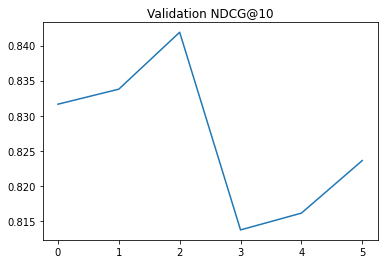

In [18]:
plt.plot(ndcg_val)
plt.title("Validation NDCG@10")

#from google.colab import files
plt.savefig(model_dir + "ndcg.png")
#files.download(model_dir + "ndcg.png") 

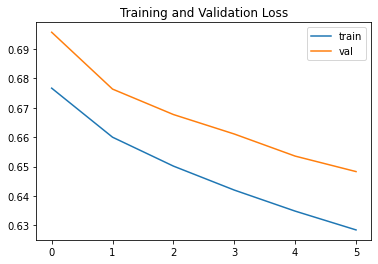

In [19]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend()
plt.title("Training and Validation Loss")

#from google.colab import files
plt.savefig(model_dir + "loss.png")
#files.download(model_dir + "loss.png") 

## **BERT**: Get predictions

In [20]:
batch_size= 32
res = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])
dataset_test= LFM2bDataset(data_interaction_test,tokenizer,item_text_embeddings_size, text_col,  item2pos, user2id)
# dataset_test= LFM2bDatasetMulitpleText(data_interaction_test,tokenizer,item_text_embeddings_size,  item2pos, user2id)
dataloader_test=DataLoader(dataset=dataset_test,batch_size=batch_size, num_workers=4)

model = AMARBert(item_embeddings_size, item_text_embeddings_size, user_embeddings_size, num_users, num_items, BERT_MODEL_NAME)

model.load_state_dict(torch.load(model_dir + 'best_model.pth'))
model.to(device)
model.eval()


for data in dataloader_test:
      gc.collect()
      torch.cuda.empty_cache()
      #items positions
      curr_items_ids_batch = data['track_id']
      # items descriptions
      curr_items_batch = data['input_ids_lyrics']
      curr_attentions_batch = data['attention_mask_lyrics']

      # additional items descriptions
      # curr_items_batch1 = data['input_ids_tags']
      # curr_attentions_batch1 = data['attention_mask_tags']
      
      # users ids
      curr_users_batch =data['user_id']

      # model inputs
      inputs = [curr_items_ids_batch.type(torch.LongTensor).to(device), 
                curr_items_batch.type(torch.LongTensor).to(device), 
                curr_users_batch.type(torch.LongTensor).to(device), 
                curr_attentions_batch.type(torch.LongTensor).to(device),
                # curr_items_batch1.type(torch.LongTensor).to(device), 
                # curr_attentions_batch1.type(torch.LongTensor).to(device),
                ]
      user_id = curr_users_batch.type(torch.LongTensor).to(device)
      input_id = curr_items_ids_batch.type(torch.LongTensor).to(device)
      input_text_ids = curr_items_batch.type(torch.LongTensor).to(device)
      attention_mask = curr_attentions_batch.type(torch.LongTensor).to(device) 


      with torch.no_grad():
        outputs = model(user_id, input_id, input_text_ids, attention_mask)

      # save prediction for each user
      for i in range(outputs.shape[0]):

        res = res.append(pd.DataFrame({'user_id': id2user[curr_users_batch[i].item()], 'track_id': pos2item[curr_items_ids_batch[i].item()], 'count':  outputs[i].item()} , index=[0]))
        

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
topn=100
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user, user_prediction in res.groupby('user_id'):
    results_df = results_df.append(user_prediction.sort_values('count', ascending=False).head(topn))
    

In [22]:
results_df.to_csv(model_dir + 'predictions.csv', encoding = 'utf-8-sig') 

# Most popular recommendation


In [23]:
topn = 100

item_popularity_df = data_interaction_test.groupby('track_id')['count'].sum().sort_values(ascending=False).reset_index()

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train['user_id'] == real_user_id]['track_id'].values
    item_popularity_df_user = item_popularity_df#[~item_popularity_df['track_id'].isin(items_to_ignore)]
    predictions[real_user_id].append(item_popularity_df_user.head(topn)['track_id'].values.tolist())

In [24]:
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={'user_id':[user],'track_id':[item],'count':[rating]})))
        results.append([user, item, rating])

# Random recommendation

In [32]:
topn = 100
import random

predictions = {}

for real_user_id in data_interaction_test.user_id.unique():
    predictions[real_user_id] = []
    items_to_ignore = data_interaction_train[data_interaction_train['user_id'] == real_user_id]['track_id'].values
    item_df_user = data_interaction_test[~data_interaction_test['track_id'].isin(items_to_ignore)]
    predictions[real_user_id].append(random.sample(set(item_df_user['track_id'].values), topn))

In [33]:
results = []
results_df = pd.DataFrame(columns = ['user_id', 'track_id', 'count'])

for user in predictions:
    user_prediction = predictions[user][0]
    for item in user_prediction:
        rating = 1.
        results_df = pd.concat((results_df, pd.DataFrame(data={'user_id':[user],'track_id':[item],'count':[rating]})))
        results.append([user, item, rating])

# Evaluate predictions

Scores: F1@10, ndcg@k, recall@k

In [18]:
topn=100

In [19]:
results_df = pd.read_csv(model_dir + "predictions.csv").drop(["Unnamed: 0"], axis=1)

In [25]:
f1_scores = []
recall_scores = []
ndcg_scores = []

for user, df in results_df.groupby('user_id'):
  df = df.drop_duplicates(subset='track_id')

  y_true_sorted = data_interaction_test.loc[data_interaction_test['user_id'] == user].sort_values('count', ascending=False).drop_duplicates()
  rel = pd.merge(df[['track_id']], y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)['count'].values
  y_true_df = pd.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), y_true_sorted[['track_id', 'count']].drop_duplicates(), 'left').fillna(0)
  y_ndcg = rel#['count'].values
  y_ndcg[y_ndcg > 0] = 1
  y_true_df.loc[y_true_df['count'] > 0, 'count'] = 1
  y_true = y_true_df['count'].values

  y_pred_df = pd.merge(data_tracks_tags_lyrics[['track_id']].drop_duplicates(), df[['track_id', 'count']], 'left').fillna(0)
  y_pred_df.loc[y_pred_df['count'] > 0, 'count'] = 1
  y_pred = y_pred_df['count'].values

  if y_true.sum() >= 1:
    f1_scores.append(f1_score(y_true, y_pred))
    recall_scores.append(recall_score(y_true, y_pred))
    ndcg_scores.append(get_ndcg(y_ndcg, topn))

coverage = get_coverage(results_df, data_tracks_tags_lyrics)

print("F1 Score: ", np.mean(f1_scores))
print("Recall Score: ", np.mean(recall_scores))
print("NDCG Score: ", np.mean(ndcg_scores))
print("Coverage: , ", coverage)

F1 Score:  0.08008416666709478
Recall Score:  0.3015946290796202
NDCG Score:  0.05854672215260055
Coverage: ,  0.038789759503491075


In [ ]:
pd.DataFrame({"f1_score": [np.mean(f1_scores)], 
              'recall': [np.mean(recall_scores)], 
              'ndcg': [np.mean(ndcg_scores)],
              'coverage': [coverage]}).to_csv(model_dir + 'evaluation_result.csv', encoding = 'utf-8-sig') 